In [6]:
#Imports
import re
import pandas as pd
import requests, sys, json
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_unweighted

In [7]:
#Keywords que funcionarán para filtrar los resultados de acuerdo al tipo de familia/dominio
keywords = ["DNA-binding", "Helix-turn-helix",
            "Helix-loop-helix", "zinc finger",
            "Leucine zipper", "Winged",
            "bHLH", "Winged helix",
            "winged-helix", "helix turn helix",
            "leucine-zipper", "zinc-finger",
            "Zn-finger", "Zinc finger",
            "Sigma","sigma[-]*", "basic-leucine","leucine zipper",
            "Homeodomain-like", "Homeodomain", "HemN-like",
            "transcription factor",
            "Regulator", "Regulatory", "Histon-like",
            "Nucleic acid-binding", "Winged helix",
            "winged-helix", "HTH",
            "DNA binding", "nucleoid-associated"]

In [8]:
#Apertura de archivos
with open('domains_buc_proteome.tsv', 'r', ) as buc, open('IPR_list.tsv', 'r') as ipr, open('interpro2go.txt', 'r') as i2go, open('ipr_web_results.tsv', 'r') as web:
    iprscan_out, ipr_list, ipr_go, w_ipr = buc.readlines(),  ipr.readlines(), i2go.readlines(), web.readlines()
    #Lista de listas de IPR_list formato: [[InterProAcc, Tipo, Nombre]] Tipo corresponde a Dominio, familia, etc. nombre para nombre de dominio
    iprscan_output = [i.split('\t') for i in iprscan_out]
    ipr_type_name = [i.replace('\n', '').split('\t') for i in ipr_list[1:]]
    ipr2go = [i.replace('\n', '').replace(' ', '>', 1).replace(';', '>').replace(' ', '').replace('InterPro:', '').split('>') for i in ipr_go[5:]]
    web_ipr = [[i.split('\t')[0], i.split('\t')[1], i.split('\t')[4], i.replace('\n', '').split('\t')[6]] for i in w_ipr[1:]]

In [9]:
#plantear una función que tome los keywords como argumentos y la lista ipr_type_name para filtrar los
#IPRaccession numbers de acuerdo a las keywords
def filter_by_kwds(keys, iprs):
    """
    Esta función se encarga de tomar una serie de keywords declaradas en una lista, y con ellas filtrar
    los IPR ACS provenientes de InterPro con la información de cada uno de los dominios, familias, sitios, etc
    ARGS:
        keys: keywords para filtrar
        iprs: lista con listas de los IPR accession numbers, dominio/familia/etc..., nombre
    RETURNS
        ipr_type_name_filtred
    """
    ipr_type_name_filtred = [r for r in iprs if any(k.lower() in r[2].lower() for k in keys)]
    return ipr_type_name_filtred
#Plantear una función que ayude a filtrar posibles GO's relacionados a la regulación
#haciendo uso del filter_by_kwds
def obtain_reulatory_gos(ipr_filt, ipr_gos, nombre):
    """
    Esta función se encarga de comparar un archivo de InterPro accession filtrados para un tipo de dominio o familia con uno
    que relaciona InterPro numbers y GO's de InterPro, para obtener al final una lista de posibles GOs relacionados con la 
    regulación.
    ARGS:
        ipr_filt: es una relación de listas de listas con los ipr filtrados previamente con keywords
        ipr_gos: es una lista de listas con IPR accesions, anotacionIPR, anotaciónGO, GO Term
    """
    r_gos = []
    for i in ipr_filt:
        for j in ipr_gos:
            if i[0] == j[0]:
                r_gos.append(j[-1])
    r_gos = list(set(r_gos))
    with open(nombre, 'w') as g:
        for i in r_gos:
            print(i, file=g)
    return r_gos
#Planteo de una función para filtrar la salida de InterProScan que estén anotados con algun IPR accession number
def filter_ipscan_by_ipr(iprscan, iprfilt):
    """
    Esta función se encarga de filtrar una salidade InterPro scan con una lista de IPR accession numbers filtrados para un tipo de 
    dominio, como aquellos encargados de la regulación genética, estos últimos deben ser filtrados con keywords.
    ARGS:
        iprscan: es la salida procesada en forma de listas de listas de InterProScan
        iprfilt: son los IPR accession numbers filtrados por keywords
    RETURNS:
        iprscan_filtred
    """
    iprscan_filtred = []
    for i in iprfilt:
        for j in iprscan:
            if i[0] == j[11]:
                f = [j[0], i[0], i[2], i[1], j[13]]
                iprscan_filtred.append(f)
    return iprscan_filtred
#Funcion que filtra por gos la salida prefiltrada de InterProScan
def filter_iprscan_by_gos(iprs, reg_gos, score):
    """
    Esta función se encarga de filtrar una salida prefiltrada de InterProScan a través de IPR accession numbers.
    Aquí se podrá filtrar esta última por GOs asociados a la regulación genética.
    ARGS:
        iprs: salida prefiltrada de InterProScan
        reg_gos: lista de GO relacionados a regulación u otro.
        score: score que el usuario desee rescatar del filtro
    RETURNS:
        one: proteinas con score de confiabilidad 1, tienen GO pero no relacionado a regulación
        two: proteinas con score de confiabilidad 2, no tienen GO
        three: proteinas con score de confiabilidad 3, tienen GO relacionado a la regulación
    """
    one = [i for i in iprs if i[-1] != '-' and not any(go in i[-1] for go in reg_gos)]
    two = [i for i in iprs if i[-1] == '-']
    three = [i for i in iprs if i[-1] != '-' and any (go in i[-1] for go in reg_gos)]
    if score == 1:
        return one
    elif score == 2:
        return two
    elif score == 3:
        return three
    else:
        print('Los scores solo van de 1 a 3, elija: 1, 2, o 3')
#Funcion que se encarga de extraer información como protein IDS, IPR accession numbers de una lista de listas
def extract_info(patron, ipr):
    """
    Documentación

    """
    p = re.compile(patron)
    info = [(re.search(p, r[0]).group(1), r[1], r[2], r[3], r[4]) for r in ipr]
    return info
#función que se encarga de hacer solicitudes a la API de un sitio web
def get_url(url, **kwargs):
    """
    Documentación
    """
    response = requests.get(url, **kwargs)
    if not response.ok:
        print(response.text)
        response.raise_for_status()
        sys.exit()
    return response
# Función que extrae información desde la website api de las proteinas proporcionadas
def consult_from_uniprot(website, proteins, resp):
    """
    Documentacion
    DE MOMENTO SOLO FUNCIONA PARA EXTRAER NOMBRES DE GENES Y PROTEINAS
    ESTARÍA COOL DEJARLA PARA PEDIRLE LA INFORMACIÓN QUE SE REQUIERA
    """
    info_proteins = []
    for i in proteins:
        try:
            req = resp(f"{website}/uniprotkb/{i[0]}")
            api_data = req.json()
            gene = api_data['genes'][0]['geneName']['value']
            prot = api_data['proteinDescription']['recommendedName']['fullName']['value']
            f = [i[0], gene, prot, i[2], i[3], i[1], i[4].replace('|', ', ')]
            info_proteins.append(f)
        except:
            s = f'No info for: {i[0]}'
            info_proteins.append(s)
    return info_proteins

In [10]:
filter_by_kwds(keywords, ipr_type_name)

[['IPR015887',
  'Binding_site',
  'DNA glycosylase/AP lyase, zinc finger domain, DNA-binding site'],
 ['IPR025662',
  'Binding_site',
  'Sigma-54 interaction domain, ATP-binding site 1'],
 ['IPR025943',
  'Binding_site',
  'Sigma-54 interaction domain, ATP-binding site 2'],
 ['IPR000047', 'Conserved_site', 'Helix-turn-helix motif'],
 ['IPR000637', 'Conserved_site', 'HMG-I/HMG-Y, DNA-binding, conserved site'],
 ['IPR000838',
  'Conserved_site',
  'RNA polymerase sigma factor 70, ECF, conserved site'],
 ['IPR001562', 'Conserved_site', 'Zinc finger, Btk motif'],
 ['IPR003956',
  'Conserved_site',
  'Transcription factor, NFYB/HAP3, conserved site'],
 ['IPR005486',
  'Conserved_site',
  'Glucokinase regulatory protein, conserved site'],
 ['IPR013734', 'Conserved_site', 'Transcription factor Nrm1/Whi5'],
 ['IPR017907', 'Conserved_site', 'Zinc finger, RING-type, conserved site'],
 ['IPR017918',
  'Conserved_site',
  'Nitrogen regulatory protein PII, conserved site'],
 ['IPR017956', 'Conserv

In [11]:
#1
interpro_type_name_filt = filter_by_kwds(keywords, ipr_type_name)

In [12]:
#2
name = 'put_reg_go.txt'
regulatory_gos = obtain_reulatory_gos(interpro_type_name_filt, ipr2go, name)
regulatory_gos

['GO:0044325',
 'GO:0000976',
 'GO:0006888',
 'GO:0042025',
 'GO:0045122',
 'GO:0042981',
 'GO:0019781',
 'GO:0003950',
 'GO:0016586',
 'GO:0016987',
 'GO:0017183',
 'GO:0045600',
 'GO:0004864',
 'GO:0030238',
 'GO:0007015',
 'GO:0035198',
 'GO:0006282',
 'GO:0005694',
 'GO:2000031',
 'GO:0097367',
 'GO:0006391',
 'GO:0006351',
 'GO:0016514',
 'GO:0009432',
 'GO:0009909',
 'GO:0009890',
 'GO:0009736',
 'GO:0004402',
 'GO:0006813',
 'GO:0019901',
 'GO:0000166',
 'GO:0044781',
 'GO:0003697',
 'GO:0035307',
 'GO:1901894',
 'GO:0000126',
 'GO:0006011',
 'GO:0010045',
 'GO:0045116',
 'GO:0005643',
 'GO:0005524',
 'GO:0042176',
 'GO:0019629',
 'GO:0042372',
 'GO:0000981',
 'GO:0042054',
 'GO:0015074',
 'GO:0016197',
 'GO:0031931',
 'GO:0001228',
 'GO:0000439',
 'GO:0004523',
 'GO:0007165',
 'GO:0007420',
 'GO:0004222',
 'GO:0042174',
 'GO:0002218',
 'GO:0050709',
 'GO:0006959',
 'GO:0008380',
 'GO:0000226',
 'GO:0004842',
 'GO:0009347',
 'GO:0031929',
 'GO:2000146',
 'GO:0010468',
 'GO:00314

In [13]:
### ObTENER UN DICCIONARIO CON KEYS LOS GENES Y VALUES UN SET DE SUS IPRS CON EL RESULTADO DE LA WEB
gen_iprs = {}
for i in web_ipr:
    if i[0] not in gen_iprs:
        ip = set()
        gen_iprs[i[0]] = ip
        if i[2].startswith('IPR'):
            gen_iprs[i[0]].add(i[2])
        else: continue
    elif i[0] in gen_iprs and i[2].startswith('IPR'):
        gen_iprs[i[0]].add(i[2])

In [15]:
#Probar si los sets para cada gen son subsets con los obtenidos de interpro scan
iprscan_output

[['sp|P57575|RL18_BUCAI',
  'd51f2eb45a7abd2c6a803322aa1e8d15',
  '122',
  'Pfam',
  'PF00861',
  'Ribosomal L18 of archaea, bacteria, mitoch. and chloroplast',
  '8',
  '122',
  '3.5E-31',
  'T',
  '24-01-2024',
  'IPR005484',
  'Large ribosomal subunit protein uL18',
  'GO:0003735(InterPro)|GO:0005840(InterPro)|GO:0006412(InterPro)',
  'Reactome:R-BTA-5389840|Reactome:R-BTA-5419276|Reactome:R-CEL-5389840|Reactome:R-CEL-5419276|Reactome:R-HSA-5368286|Reactome:R-HSA-5389840|Reactome:R-HSA-5419276|Reactome:R-MMU-5389840|Reactome:R-MMU-5419276\n'],
 ['sp|P57575|RL18_BUCAI',
  'd51f2eb45a7abd2c6a803322aa1e8d15',
  '122',
  'PANTHER',
  'PTHR12899',
  '39S RIBOSOMAL PROTEIN L18, MITOCHONDRIAL',
  '12',
  '122',
  '2.6E-23',
  'T',
  '24-01-2024',
  'IPR005484',
  'Large ribosomal subunit protein uL18',
  'GO:0003735(InterPro)|GO:0005840(InterPro)|GO:0006412(InterPro)|GO:0008097(PANTHER)|GO:0022625(PANTHER)',
  'Reactome:R-BTA-5389840|Reactome:R-BTA-5419276|Reactome:R-CEL-5389840|Reactome:R

In [26]:
db = [i[3] for i in iprscan_output]

In [29]:
#medidas de tendencia central
import numpy as np
Counter(db)

Counter({'Pfam': 971,
         'PANTHER': 549,
         'CDD': 430,
         'NCBIfam': 485,
         'Hamap': 402,
         'PIRSF': 147})

In [16]:
interpro_type_name_filt

[['IPR015887',
  'Binding_site',
  'DNA glycosylase/AP lyase, zinc finger domain, DNA-binding site'],
 ['IPR025662',
  'Binding_site',
  'Sigma-54 interaction domain, ATP-binding site 1'],
 ['IPR025943',
  'Binding_site',
  'Sigma-54 interaction domain, ATP-binding site 2'],
 ['IPR000047', 'Conserved_site', 'Helix-turn-helix motif'],
 ['IPR000637', 'Conserved_site', 'HMG-I/HMG-Y, DNA-binding, conserved site'],
 ['IPR000838',
  'Conserved_site',
  'RNA polymerase sigma factor 70, ECF, conserved site'],
 ['IPR001562', 'Conserved_site', 'Zinc finger, Btk motif'],
 ['IPR003956',
  'Conserved_site',
  'Transcription factor, NFYB/HAP3, conserved site'],
 ['IPR005486',
  'Conserved_site',
  'Glucokinase regulatory protein, conserved site'],
 ['IPR013734', 'Conserved_site', 'Transcription factor Nrm1/Whi5'],
 ['IPR017907', 'Conserved_site', 'Zinc finger, RING-type, conserved site'],
 ['IPR017918',
  'Conserved_site',
  'Nitrogen regulatory protein PII, conserved site'],
 ['IPR017956', 'Conserv

In [17]:
#3
interproscan_output_filt = filter_ipscan_by_ipr(iprscan_output, interpro_type_name_filt)
interproscan_output_filt

[['sp|P57294|DKSA_BUCAI',
  'IPR000962',
  'Zinc finger, DksA/TraR C4-type',
  'Domain',
  'GO:0008270(InterPro)'],
 ['sp|P63237|CSPE_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P63237|CSPE_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P57407|CSPC_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P57407|CSPC_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P57480|FIS_BUCAI',
  'IPR002197',
  'DNA binding HTH domain, Fis-type',
  'Domain',
  'GO:0043565(InterPro)'],
 ['sp|P57164|DNAG_BUCAI',
  'IPR002694',
  'Zinc finger, CHC2-type',
  'Domain',
  'GO:0003677(InterPro)|GO:0003896(InterPro)|GO:0006260(InterPro)|GO:0008270(InterPro)'],
 ['sp|P57163|RPOD_BUCAI',
  'IPR007127',
  'RNA polymerase sigma factor 70, region 1.1',
  'Domain',
  'GO:0003677(InterPro)|GO:

In [36]:
#4
posible_regulatory_proteins = filter_iprscan_by_gos(interproscan_output_filt, regulatory_gos, 3)
posible_regulatory_proteins

[['sp|P57294|DKSA_BUCAI',
  'IPR000962',
  'Zinc finger, DksA/TraR C4-type',
  'Domain',
  'GO:0008270(InterPro)'],
 ['sp|P63237|CSPE_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P63237|CSPE_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P57407|CSPC_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P57407|CSPC_BUCAI',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'],
 ['sp|P57480|FIS_BUCAI',
  'IPR002197',
  'DNA binding HTH domain, Fis-type',
  'Domain',
  'GO:0043565(InterPro)'],
 ['sp|P57164|DNAG_BUCAI',
  'IPR002694',
  'Zinc finger, CHC2-type',
  'Domain',
  'GO:0003677(InterPro)|GO:0003896(InterPro)|GO:0006260(InterPro)|GO:0008270(InterPro)'],
 ['sp|P57163|RPOD_BUCAI',
  'IPR007127',
  'RNA polymerase sigma factor 70, region 1.1',
  'Domain',
  'GO:0003677(InterPro)|GO:

In [37]:
#5
patron = r'sp\|([A-Za-z0-9]+)\|'
protein_info = extract_info(patron, posible_regulatory_proteins)
protein_info

[('P57294',
  'IPR000962',
  'Zinc finger, DksA/TraR C4-type',
  'Domain',
  'GO:0008270(InterPro)'),
 ('P63237',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'),
 ('P63237',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'),
 ('P57407',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'),
 ('P57407',
  'IPR002059',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'GO:0003676(InterPro)'),
 ('P57480',
  'IPR002197',
  'DNA binding HTH domain, Fis-type',
  'Domain',
  'GO:0043565(InterPro)'),
 ('P57164',
  'IPR002694',
  'Zinc finger, CHC2-type',
  'Domain',
  'GO:0003677(InterPro)|GO:0003896(InterPro)|GO:0006260(InterPro)|GO:0008270(InterPro)'),
 ('P57163',
  'IPR007127',
  'RNA polymerase sigma factor 70, region 1.1',
  'Domain',
  'GO:0003677(InterPro)|GO:0006355(InterPro)'),
 ('P57163',
  'IPR007624',
  'RNA polymerase sigma-70 region 3',
  'Domain',
  'GO:0003700

In [38]:
#6
WEBISTE_API = "https://rest.uniprot.org/"
#documentación: https://ww.ebi.ac.uk/proteins/api/doc/
PROTEINS_API = "https://www.ebi.ac.uk/proteins/api"
# link = get_url(f)

In [39]:
#7
prot_gen_dom = consult_from_uniprot(WEBISTE_API, protein_info, get_url)
prot_gen_dom

[['P57294',
  'dksA',
  'RNA polymerase-binding transcription factor DksA',
  'Zinc finger, DksA/TraR C4-type',
  'Domain',
  'IPR000962',
  'GO:0008270(InterPro)'],
 ['P63237',
  'cspE',
  'Cold shock-like protein CspE',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P63237',
  'cspE',
  'Cold shock-like protein CspE',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P57407',
  'cspC',
  'Cold shock-like protein CspC',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P57407',
  'cspC',
  'Cold shock-like protein CspC',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P57480',
  'fis',
  'DNA-binding protein Fis',
  'DNA binding HTH domain, Fis-type',
  'Domain',
  'IPR002197',
  'GO:0043565(InterPro)'],
 ['P57164',
  'dnaG',
  'DNA primase',
  'Zinc finger, CHC2-type',
  'Domain',
  'IPR002694',
  'GO:0003

In [40]:
len(set([i[0] for i in prot_gen_dom])), ([i[1] for i in prot_gen_dom])
prot_gen_dom

[['P57294',
  'dksA',
  'RNA polymerase-binding transcription factor DksA',
  'Zinc finger, DksA/TraR C4-type',
  'Domain',
  'IPR000962',
  'GO:0008270(InterPro)'],
 ['P63237',
  'cspE',
  'Cold shock-like protein CspE',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P63237',
  'cspE',
  'Cold shock-like protein CspE',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P57407',
  'cspC',
  'Cold shock-like protein CspC',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P57407',
  'cspC',
  'Cold shock-like protein CspC',
  'Cold-shock protein, DNA-binding',
  'Domain',
  'IPR002059',
  'GO:0003676(InterPro)'],
 ['P57480',
  'fis',
  'DNA-binding protein Fis',
  'DNA binding HTH domain, Fis-type',
  'Domain',
  'IPR002197',
  'GO:0043565(InterPro)'],
 ['P57164',
  'dnaG',
  'DNA primase',
  'Zinc finger, CHC2-type',
  'Domain',
  'IPR002694',
  'GO:0003

In [41]:
for row in prot_gen_dom:
    print(row)

['P57294', 'dksA', 'RNA polymerase-binding transcription factor DksA', 'Zinc finger, DksA/TraR C4-type', 'Domain', 'IPR000962', 'GO:0008270(InterPro)']
['P63237', 'cspE', 'Cold shock-like protein CspE', 'Cold-shock protein, DNA-binding', 'Domain', 'IPR002059', 'GO:0003676(InterPro)']
['P63237', 'cspE', 'Cold shock-like protein CspE', 'Cold-shock protein, DNA-binding', 'Domain', 'IPR002059', 'GO:0003676(InterPro)']
['P57407', 'cspC', 'Cold shock-like protein CspC', 'Cold-shock protein, DNA-binding', 'Domain', 'IPR002059', 'GO:0003676(InterPro)']
['P57407', 'cspC', 'Cold shock-like protein CspC', 'Cold-shock protein, DNA-binding', 'Domain', 'IPR002059', 'GO:0003676(InterPro)']
['P57480', 'fis', 'DNA-binding protein Fis', 'DNA binding HTH domain, Fis-type', 'Domain', 'IPR002197', 'GO:0043565(InterPro)']
['P57164', 'dnaG', 'DNA primase', 'Zinc finger, CHC2-type', 'Domain', 'IPR002694', 'GO:0003677(InterPro), GO:0003896(InterPro), GO:0006260(InterPro), GO:0008270(InterPro)']
['P57163', 'rpo

In [24]:
#construyendo data frame y exportando resultados
col_names = ["UniProtkbID", "Gene Name", "Protein Name", "Domain/Family/Active site", "Type", "InterPro", "GO"]
df_results = pd.DataFrame(prot_gen_dom, columns=col_names)
df_results.to_csv('resultados_IPR_2024.tsv', sep='\t', index=False)
df_results

ValueError: 7 columns passed, passed data had 19 columns

In [2]:
with open('resultados_interpro_filtrados.tsv', 'r') as x:#, open('resultados_interpro_filtrados_sinGO.tsv', 'r') as y:
    # info_x, info_y = x.readlines(), y.readlines()
    info_x = x.readlines()
    con_gos = [i.split('\t') for i in info_x[1:]]
    # sin_gos = [i.split('\t') for i in info_y[1:]]
    set_con_gos = set([i[1] for i in con_gos])
    # set_sin_gos = set([i[1] for i in sin_gos])

In [5]:
set_con_gos

{'clpX',
 'cspC',
 'cspE',
 'csrA',
 'dksA',
 'dnaG',
 'fis',
 'hisS',
 'hup',
 'ihfA',
 'ihfB',
 'ligA',
 'nusA',
 'priA',
 'pyrI',
 'rpoD',
 'rpoH',
 'ssb',
 'topA'}

In [ ]:
with open('resultados_interpro_filtrados.tsv', 'r') as filt:
    scan = filt.readlines()
    scan_ipr = [[i.split('\t')[1], i.split('\t')[5]] for i in scan[1:]]
    scan_ipr

In [ ]:
scan_ipr

[['ihfB', 'IPR020816'],
 ['hup', 'IPR020816'],
 ['ihfA', 'IPR020816'],
 ['rpoH', 'IPR000943'],
 ['rpoH', 'IPR000943'],
 ['rpoH', 'IPR000943'],
 ['rpoH', 'IPR000943'],
 ['rpoH', 'IPR000943'],
 ['rpoH', 'IPR000943'],
 ['rpoD', 'IPR000943'],
 ['rpoD', 'IPR000943'],
 ['rpoD', 'IPR000943'],
 ['rpoD', 'IPR000943'],
 ['rpoD', 'IPR000943'],
 ['rpoD', 'IPR000943'],
 ['rpoD', 'IPR000943'],
 ['dksA', 'IPR000962'],
 ['cspE', 'IPR002059'],
 ['cspE', 'IPR002059'],
 ['cspE', 'IPR002059'],
 ['cspE', 'IPR002059'],
 ['cspE', 'IPR002059'],
 ['cspE', 'IPR002059'],
 ['cspC', 'IPR002059'],
 ['cspC', 'IPR002059'],
 ['cspC', 'IPR002059'],
 ['cspC', 'IPR002059'],
 ['cspC', 'IPR002059'],
 ['cspC', 'IPR002059'],
 ['fis', 'IPR002197'],
 ['fis', 'IPR002197'],
 ['fis', 'IPR002197'],
 ['dnaG', 'IPR002694'],
 ['dnaG', 'IPR002694'],
 ['ligA', 'IPR003583'],
 ['ligA', 'IPR003583'],
 ['ligA', 'IPR003583'],
 ['topA', 'IPR003602'],
 ['rpoD', 'IPR007127'],
 ['rpoD', 'IPR007624'],
 ['rpoH', 'IPR007627'],
 ['rpoD', 'IPR007627

In [7]:
#Probar si los sets para cada gen son subsets con los obtenidos de interpro scan
#procesar archivo de informacion
### ObTENER UN DICCIONARIO CON KEYS LOS GENES Y VALUES UN SET DE SUS IPRS
gen_iprs_output = {}
for i in scan_ipr:
    if i[0] not in gen_iprs_output:
        ip = set()
        gen_iprs_output[i[0]] = ip
        if i[1].startswith('IPR'):
            gen_iprs_output[i[0]].add(i[1])
        else: continue
    elif i[0] in gen_iprs_output and i[1].startswith('IPR'):
        gen_iprs_output[i[0]].add(i[1])
gen_iprs_output

NameError: name 'scan_ipr' is not defined

In [ ]:
# probar si las anotaciones ipr de las proteinas putativas regulatorias son subsets de las anotaciones de Interprodescargadas
c = 0
for i, s1 in gen_iprs.items():
    for j, s2 in gen_iprs_output.items():
        if j == i:
            subset = s2 == s1 ###Pregunto si el set de IPRS de la salida de reguladoresw es subset de los IPRS del web
            c += 1
            print(f'{c} {j}, {i}, {len(s1)}, {len(s2)} Los IPRS son subsets {subset}')
            #revisar los que se elminan y plantear una logica de su elimincacion

1 topA, topA, 15, 1 Los IPRS son subsets False
2 dnaG, dnaG, 11, 2 Los IPRS son subsets False
3 ligA, ligA, 12, 1 Los IPRS son subsets False
4 priA, priA, 7, 1 Los IPRS son subsets False
5 nusA, nusA, 11, 2 Los IPRS son subsets False
6 rpoH, rpoH, 7, 6 Los IPRS son subsets False
7 hup, hup, 3, 3 Los IPRS son subsets True
8 rpoD, rpoD, 14, 12 Los IPRS son subsets False
9 ihfA, ihfA, 4, 3 Los IPRS son subsets False
10 dksA, dksA, 5, 2 Los IPRS son subsets False
11 hisS, hisS, 7, 1 Los IPRS son subsets False
12 ihfB, ihfB, 4, 3 Los IPRS son subsets False
13 cspC, cspC, 5, 1 Los IPRS son subsets False
14 pyrI, pyrI, 5, 1 Los IPRS son subsets False
15 fis, fis, 3, 2 Los IPRS son subsets False
16 csrA, csrA, 2, 2 Los IPRS son subsets True
17 clpX, clpX, 8, 1 Los IPRS son subsets False
18 ssb, ssb, 3, 2 Los IPRS son subsets False
19 cspE, cspE, 5, 1 Los IPRS son subsets False


In [ ]:
len(gen_iprs['topA']), len(gen_iprs_output['topA'])

(15, 1)

In [ ]:
gen_iprs.items() #salida de interpro web
# interpro_type_name_filt# IPRS filtrados por keywords
web_ipr_results = []
for i in interpro_type_name_filt:
    for j in gen_iprs:
        if i[0] in gen_iprs[j]:
            r = [j, i[0], i[1], i[2]]
            web_ipr_results.append(r)
genes_web_regs = set([i[0] for i in web_ipr_results]) #genes web result

In [ ]:
set_prot_gen_dom = set([i[1] for i in prot_gen_dom])
set_prot_gen_dom, genes_web_regsss

({'clpX',
  'cspC',
  'cspE',
  'csrA',
  'dksA',
  'dnaG',
  'fis',
  'hisS',
  'hup',
  'ihfA',
  'ihfB',
  'ligA',
  'nusA',
  'priA',
  'pyrI',
  'rpoD',
  'rpoH',
  'ssb',
  'topA'},
 {'asnS',
  'aspS',
  'clpX',
  'cspC',
  'cspE',
  'csrA',
  'dksA',
  'dnaG',
  'dnaT',
  'efp',
  'fis',
  'hisG',
  'hisS',
  'hup',
  'ihfA',
  'ihfB',
  'ileS',
  'ilvH',
  'infA',
  'infB',
  'ligA',
  'lysS',
  'mutL',
  'nusA',
  'pheT',
  'pnp',
  'priA',
  'pyrI',
  'rho',
  'rnb',
  'rne',
  'rnr',
  'rplB',
  'rpoD',
  'rpoH',
  'rpsA',
  'rpsL',
  'rpsQ',
  'ssb',
  'topA'})

# Operaciones de conjuntos entre genes con GOs, sin GOs, Brizna, HMMER y P2TF

In [ ]:
def venns(set1, set2, labels):
    venn_diagram = venn2(subsets=(set1, set2), set_labels=labels)
    #modificar manualmente el diagrama de venn
    #obtener intersecciones y diferencias
    inter = set1.intersection(set2)
    gos_nogos = set1.difference(set2)
    nogos_gos =set2.difference(set1)
    #anotar intersecciones y diferencias
    # Anotar las intersecciones y diferencias
    venn_diagram.get_label_by_id('10').set_text('\n'.join(gos_nogos))
    venn_diagram.get_label_by_id('01').set_text('\n'.join(nogos_gos))
    venn_diagram.get_label_by_id('11').set_text('\n'.join(inter))

    # Mostrar el diagrama
    return plt.show(), len(gos_nogos), len(inter), len(nogos_gos)

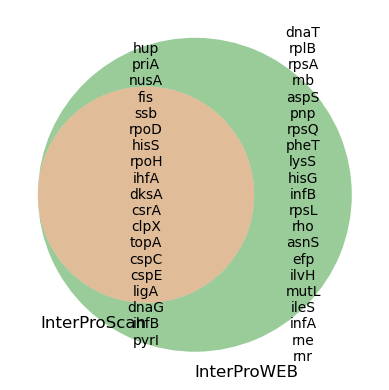

(None, 0, 19, 21)

In [ ]:
l = ['InterProScan', 'InterProWEB']
venns(set_prot_gen_dom, genes_web_regs, l)

In [ ]:
#operaciones de conjuntos entre genes con score de 3 y brizna
birizna_genes={"rpoD", "rpoH", "alaS", "bolA", "pepA", 
               "dksA", "cspC", "cspE", "csrA", "ychA", 
               "yrbA", "fis", "ihfA", "ihfB", "hup", 
               "ybaB", "topA", "gyrA", "gyrB"}

In [ ]:
#interseccion entre pyHmmer e InterproScan
hmmer_genes = {'rpoD', 'surA', 'cspC', 'leuA', 'ihfB', 'ung', 'hscA', 'dnaT', 'rpoH', 'BU482', 'dnaG', 'topA', 'mtlD', 'cspE', 'rnr', 'hemW', 'hup', 'clpX', 'priA', 'fis', 'ihfA', 'ileS', 'ligA', 'dksA', 'clsA', 'sucB'}
# len(set_con_gos.intersection(hmmer_genes)), set_con_gos.intersection(hmmer_genes)

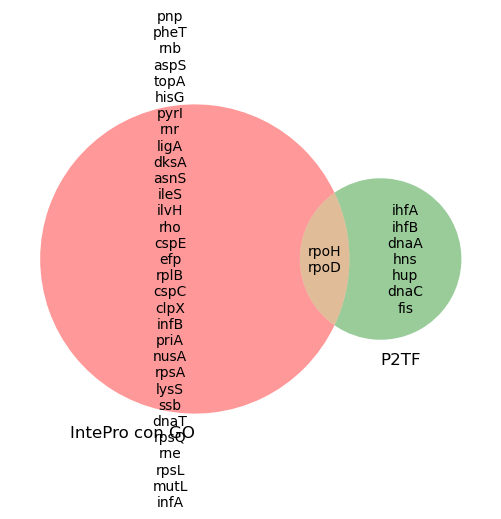

{'asnS',
 'aspS',
 'clpX',
 'cspC',
 'cspE',
 'dksA',
 'dnaT',
 'efp',
 'hisG',
 'ileS',
 'ilvH',
 'infA',
 'infB',
 'ligA',
 'lysS',
 'mutL',
 'nusA',
 'pheT',
 'pnp',
 'priA',
 'pyrI',
 'rho',
 'rnb',
 'rne',
 'rnr',
 'rplB',
 'rpoD',
 'rpoH',
 'rpsA',
 'rpsL',
 'rpsQ',
 'ssb',
 'topA'}

In [ ]:
#set p2tfm hup es la dubunidad alpha de HU, set con genes y p2tf
p2tf = {'dnaC', 'rpoD', 'rpoH', 'hup', 'ihfA', 'ihfB', 'dnaA', 'fis', 'hns'}
l = ["IntePro con GO", "P2TF"]
venns(set_sin_gos, p2tf, l)
set_sin_gos

# Búsqeudade GO's Genes de Brizna